# Imports

In [4]:
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors       import LinearSegmentedColormap
from matplotlib.colors       import TwoSlopeNorm
from matplotlib.lines        import Line2D
from skimage.transform       import resize
from plottify                import autosize
from sklearn                 import metrics
from PIL                     import Image
from adjustText              import adjust_text
from scipy.cluster           import hierarchy
import statsmodels.api   as sm
import matplotlib.pyplot as plt
import numpy             as np
import seaborn           as sns
import pandas            as pd
import scanpy            as sc
import matplotlib
import anndata
import random
import fastcluster
import copy
import umap
import h5py
import sys
import os



sys.path.append('/raid/users/farzaneh/Histomorphological-Phenotype-Learning/')
from models.visualization.clusters import *
from models.evaluation.folds import load_existing_split
from models.clustering.data_processing import *
from data_manipulation.data import Data
import warnings
warnings.filterwarnings("ignore")

# Variables

In [2]:
# Workspace path.
main_path = '/raid/users/farzaneh/Histomorphological-Phenotype-Learning'

# Image dataset variables.
# dataset            = 'TCGAFFPE_LUADLUSC_5x_60pc'
# additional_dataset = 'NYUFFPE_survival_5x_60pc'
dataset = 'Meso_250_subsampled'

############# Lungsubtype
# meta_field     = 'luad'
# matching_field = 'slides'
# resolution     = 2.0
# fold_number    = 4
# groupby        = 'leiden_%s' % resolution
# meta_folder    = 'lungsubtype_nn250'
# folds_pickle   = '/media/adalberto/Disk2/PhD_Workspace/utilities/files/LUADLUSC/lungsubtype_Institutions.pkl'

############# LUAD Overall and Recurrence Free Survival
# meta_field         = 'luad'
# matching_field     = 'samples'
# resolution         = 2.0
# fold_number        = 0
# groupby            = 'leiden_%s' % resolution
# meta_folder        = 'luad_overall_survival_nn250_fold%s_NYU_v3' % fold_number
# folds_pickle       = '%s/utilities/files/LUAD/overall_survival_TCGA_folds.pkl'  % main_path
# additional_as_fold = False

############# mesosubtype
# meta_field     = 'os_event_ind'
meta_field = 'Meso_type'
matching_field = 'slides'
resolution     = 2.0
fold_number    = 0
groupby        = 'leiden_%s' % resolution
meta_folder    = 'meso_nn250'
folds_pickle   = '%s/files/pkl_Meso_250_subsampled_he_complete.pkl'%main_path
additional_as_fold = False

# Institutions.
# inst_csv   = '/media/adalberto/Disk2/PhD_Workspace/utilities/files/TCGA/TCGA_Institutions.csv'
# inst_frame = pd.read_csv(inst_csv)
# inst_frame = inst_frame[inst_frame['Study Name'].isin(['Lung adenocarcinoma', 'Lung squamous cell carcinoma'])]

# Representations.
# h5_complete_path = '%s/results/BarlowTwins_3/TCGAFFPE_LUADLUSC_5x_60pc_250K/h224_w224_n3_zdim128_filtered/hdf5_TCGAFFPE_LUADLUSC_5x_60pc_he_complete_lungsubtype_survival_filtered.h5' % main_path
# h5_additional_path = '%s/results/BarlowTwins_3/TCGAFFPE_LUADLUSC_5x_60pc_250K/h224_w224_n3_zdim128_filtered/NYU300LUAD_Survival_5x_60pc/h224_w224_n3_zdim128/hdf5_NYU300LUAD_Survival_5x_60pc_he_train_overall_progression_free_surival_filtered.h5' % main_path
# h5_additional_path = '%s/results/BarlowTwins_3/TCGAFFPE_LUADLUSC_5x_60pc_250K/h224_w224_n3_zdim128_filtered/NYUFFPE_LUADLUSC_5x_60pc/h224_w224_n3_zdim128/hdf5_NYUFFPE_LUADLUSC_5x_60pc_he_combined_filtered.h5' % main_path

h5_complete_path = '%s/results/BarlowTwins_3/Meso_250_subsampled/h224_w224_n3_zdim128/hdf5_Meso_250_subsampled_he_complete_combined_metadata_filtered.h5'%main_path
h5_additional_path = None

# File name and directories.
file_name = h5_complete_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s' % (groupby.replace('.', 'p'), fold_number)
if h5_additional_path is not None: file_additional = h5_additional_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s' % (groupby.replace('.', 'p'), fold_number)

# Mapping for links in TCGA.
# manifest_csv = '%s/utilities/files/LUADLUSC/gdc_manifest.txt' % main_path

# Slide rep and minimum tiles.
min_ti1les       = 100
type_composition = 'percent'

# Setup folder.
main_cluster_path = h5_complete_path.split('hdf5_')[0]
main_cluster_path = os.path.join(main_cluster_path, meta_folder)
adatas_path       = os.path.join(main_cluster_path, 'adatas')
figures_path      = os.path.join(main_cluster_path, 'figures')
if not os.path.isdir(figures_path):
    os.makedirs(figures_path)

# Annotations

In [3]:
# csv_annotations_path = '%s/utilities/files/LUAD/LUAD_survival_John_annotations.csv' % main_path
# annotations          = pd.read_csv(csv_annotations_path)
# annotations          = annotations.set_index('HPC')
# annotations          = annotations.replace({'other predominant tissue':'no epithelium', 'very sparse':'Very Sparse', 'severe':'Severe', 'moderate':'Moderate', 'mild':'Mild'})
# annotations          = annotations.replace({'more stroma':'More Stroma', 'more epithelium':'More Epithelium', 'no epithelium':'No Epithelium', 'roughly equal':'Roughly Equal'})

# annotations          = annotations.replace({'malignant epithelium':'Malignant Epithelium', 'elastosis or collagenosis':'Elastosis/Collagenosis',
#        'near-normal lung':'Near-normal Lung', 'reactive lung changes':'Reactive Lung Changes', 'necrosis':'Necrosis',
#        'other connective tissue':'Connective Tissue', 'vessels':'Vessels', 'airway':'Airway', 'cartilage':'Cartilage'})

annotations = pd.read_csv('%s/files/meso_annotations.csv'%main_path).fillna('')
annotations.head(5)


,HPC,Summary,category,main_pattern
0,0,"diverse patterns, tubulopapillary and solid",tumour,epithelioid
1,1,mixture of sarcomatoid and reactive fibrotic p...,tumour,sarcomatoid
2,2,papillary and discohesive epithelioid patterns,tumour,epithelioid
3,3,angulated acinar and solid patterns,tumour,epithelioid
4,4,"paucicellular, mainly hyalinised stroma",non-tumour,na


# Images

In [8]:
# Dataset images.
data = Data(dataset=dataset, marker='he', patch_h=224, patch_w=224, n_channels=3, batch_size=64, project_path=main_path, load=True)
data_dicts = dict()
data_dicts['train'] = data.training.images
data_dicts['valid'] = data.validation.images
data_dicts['test']  = data.test.images


--------------------------------------
Train Set: /raid/users/farzaneh/Histomorphological-Phenotype-Learning/datasets/Meso_250_subsampled/he/patches_h224_w224/hdf5_Meso_250_subsampled_he_train.h5
--------------------------------------
Validation Set: /raid/users/farzaneh/Histomorphological-Phenotype-Learning/datasets/Meso_250_subsampled/he/patches_h224_w224/hdf5_Meso_250_subsampled_he_validation.h5
--------------------------------------
Test Set: /raid/users/farzaneh/Histomorphological-Phenotype-Learning/datasets/Meso_250_subsampled/he/patches_h224_w224/hdf5_Meso_250_subsampled_he_test.h5
----------------------------------------------------------------------------------


# Retrieve WSI vector representations

In [5]:
# Given a label of 'meta_field' select WSI with a large ammount of HPC.
value_cluster_ids = dict()
value_cluster_ids[0] = []
value_cluster_ids[1] = [1]
only_id = True

# Read frames.
_, frame_complete, leiden_clusters = read_csvs(adatas_path, matching_field, groupby, fold_number, [[],[],[]], h5_complete_path, h5_additional_path, additional_as_fold, force_fold=None)
colors = sns.color_palette('tab20', len(leiden_clusters))

# # Read GDC Manifest
# gdc_frame = pd.read_csv(manifest_csv, delimiter='\t')
# gdc_frame['filename'] = gdc_frame['filename'].apply(lambda p: p.split('.')[0])

# Get sample representations
slide_rep_df = prepare_set_representation(frame_complete, matching_field, meta_field, groupby, leiden_clusters, type_=type_composition, min_tiles=min_ti1les)

Adata name: Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0
Train csv not found: /raid/users/farzaneh/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso_250_subsampled/h224_w224_n3_zdim128/meso_nn250/adatas/Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0_train.csv
Train csv: /raid/users/farzaneh/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso_250_subsampled/h224_w224_n3_zdim128/meso_nn250/adatas/Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0.csv
	Train set DataFrame samples: 0
	Test  set DataFrame samples: 0
Example of instances in DataFrame[slides]: MESO_69_9
Example of instances in pickle[slides]:    []


# Select WSI to visualize

In [6]:
# Number of WSI to retrieve per HPC
n_wsi_samples = 5

dropped_slides = list()
# Save WSI with cluster overlay.
for value in np.unique(slide_rep_df[meta_field].values):
    print('Meta Field %s Value: %s' % (meta_field, value))
    all_value_slides = slide_rep_df[slide_rep_df[meta_field]==value].index.tolist()
    selected_slides = get_slides_wsi_overlay(all_value_slides, slide_rep_df[leiden_clusters], value_cluster_ids[value], only_id=only_id, n_wsi_samples=n_wsi_samples)
    for cluster_id in selected_slides:
        print('\tCluster: %s' % cluster_id)
        for slide in selected_slides[cluster_id]:
            print('\t\tWSI: %s' % slide)
            dropped_slides.append(slide)


Meta Field Meso_type Value: 0
Meta Field Meso_type Value: 1
	Cluster: 1
		WSI: MESO_471_1
		WSI: MESO_471_2
		WSI: MESO_471_3
		WSI: MESO_322_16
		WSI: MESO_46_7


# Plot WSI image

In [15]:
# Add manually or overwrite.
# dropped_slides = ['TCGA-95-7944-01Z-00-DX1', 'TCGA-L9-A5IP-01Z-00-DX1']

# dropped_slides = ['MESO_75_2']
dropped_slides = ['MESO_471_1', 'MESO_471_2', 'MESO_471_3','MESO_322_16', 'MESO_46_7']
slide = dropped_slides[-2]
wsi, wsi_c, slide_clusters = get_wsi_arrays(frame_complete, groupby, slide, img_size=224, downsample=2, img_dicts=data_dicts, colors=colors, pad_pixels=0, legend_margin=1000)

		Whole Slide Image Resolution MESO_322_16: (4144, 5264)


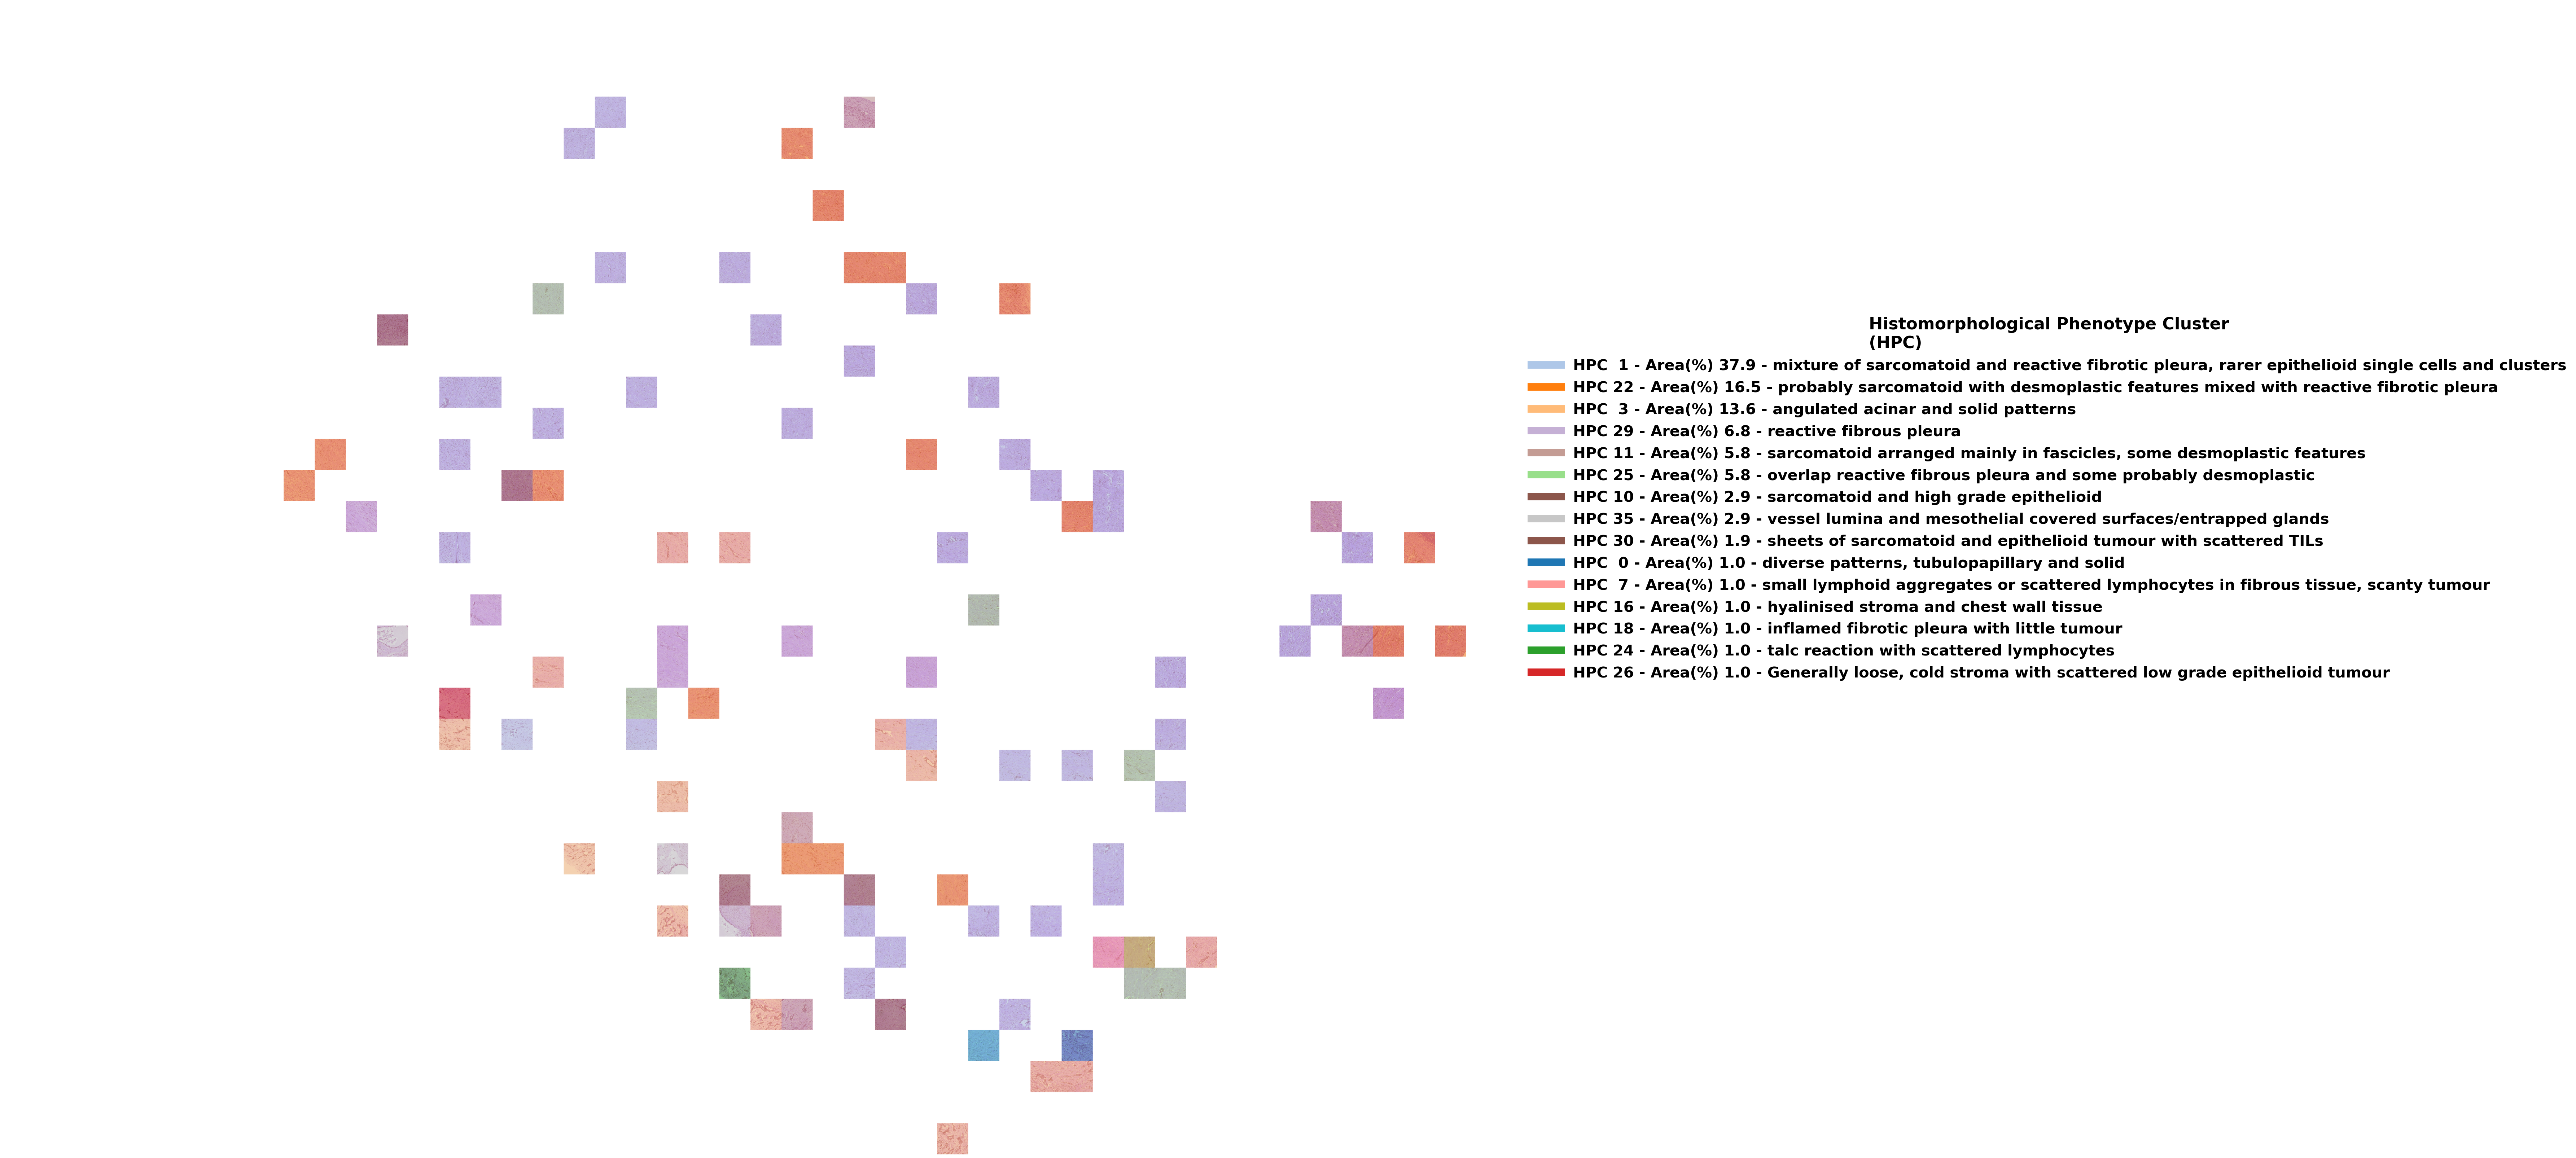

4879

In [16]:
fontsize   = 30
markersize = 15

image_clusters, counts = np.unique(slide_clusters, return_counts=True)
custom_lines = [Line2D([0], [0], color=colors[image_clusters[index]], lw=markersize) for index in np.argsort(-counts)]
names_lines  = []
for index in np.argsort(-counts):
    hpc = image_clusters[index]
    name = 'HPC %2s - Area(%s) %3s - %s' % (hpc, '%', np.round(slide_rep_df.loc[slide,hpc]*100,1), annotations.loc[hpc, 'Summary'])
    names_lines.append(name)


dpi = 100
height, width, _ = wsi.shape
figsize = width / float(dpi), height / float(dpi)
fig = plt.figure(figsize=figsize)
ax  = fig.add_subplot(1, 1, 1)
ax.imshow(wsi_c/255.)
ax.axis('off')


legend = ax.legend(custom_lines, names_lines, title='Histomorphological Phenotype Cluster\n(HPC)', frameon=False, loc='lower left', 
                   prop={'weight':'bold', 'size':fontsize}, title_fontproperties={'weight':'bold', 'size':fontsize*1.1}, bbox_to_anchor=(.87, .4))

plt.show(fig)
gc.collect()